<a href="https://colab.research.google.com/github/fcastellanosp/MINE-4210_202420_ADL/blob/main/Talleres/Taller%205/MINE4210_ADL2024_Taller5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo ADL](https://github.com/fcastellanosp/MINE-4210_202420_ADL/blob/main/Laboratorios/logo_adl.png?raw=true)

# **Taller 5**

- **Integrante 1:**
- **Integrante 2:**

La generación de imágenes ha emergido como una de las tendencias más significativas impulsadas por las Redes Neuronales Generativas (GAN). Este enfoque nos brinda la capacidad de abstraer una población específica y generar nuevas muestras de la misma. En este taller, exploraremos la aplicación de una red GAN (Generative Adversarial Network), una arquitectura de red neuronal utilizada en el aprendizaje no supervisado para generar datos novedosos y realistas.

La universidad ha sido contactada por parte de las veterinarias para generar imágenes basadas en una colección de información de gatos y perros. El objetivo es examinar el comportamiento de este conjunto de datos.

Toda la información ha sido consolidada en el siguiente [enlace](https://www.kaggle.com/datasets/marquis03/cats-and-dogs).

# **Preguntas:**

1. Realice el proceso de exploración de los datos..

2. Utilice las imágenes correspondientes para entrenar dos redes GAN. La primera red será la versión base.

3. El segundo modelo será una variante con funcionamiento condicional para la clasificación de perros y de gatos. Puedes incluir ajustes en las capas, neuronas o tipos de capas con el objetivo de mejorar los resultados.

4. Realizar la búsqueda de hiperparámetros para ambos casos.

5. Generar una tabla comparativa de los resultados obtenidos.

# **Notas Importantes:**
- El proceso propuesto debe estar debidamente codificado y justificado en cada una de las decisiones tomadas.
- La propuesta realizada es propia de cada grupo, no deben generarse procesos iguales con otros grupos de trabajo.
- No es necesario repetir el código implementado en la primera versión, debes trabajar en las mejoras/optimizaciones específicamente.
- El archivo a presentar debe ser en formato .ipynb o HTML ya ejecutado. Celda que no esté ejecutada no se podrá evaluar.
- El nombre del archivo debe ser `Taller_5_{Apellido_Nombre}_{Apellido_Nombre}` de cada integrante respectivamente.

In [2]:
!pip install kaggle -q
!pip install keras-tuner -q


In [4]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

#Librerías de Keras y Tensor Flow
import keras_tuner as kt
import keras.layers as layers
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import RandomRotation, RandomFlip, Dropout
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU ######
from tensorflow.keras.layers import Conv2D, Flatten ######
from tensorflow.keras import Sequential

#Librerías de Scikit Learn
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

#Verificamos las versiones de las librerías
print(f"La versión de sklearn es: {sklearn.__version__}")
print('Tensorflow version:', tf.__version__)

La versión de sklearn es: 1.5.2
Tensorflow version: 2.17.1


In [8]:

#Porcentaje para validación y test
test_alpha = 0.2
#random_state o semilla para la reproducibilidad
my_seed = 19
tf.random.set_seed(my_seed)
np.random.seed(my_seed)

batch_size = 24
img_height = 128
img_width = 128
band_count = 3
image_size = [img_height, img_width]

In [4]:
!ls -lha kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download marquis03/cats-and-dogs

ls: cannot access 'kaggle.json': No such file or directory
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/marquis03/cats-and-dogs
License(s): apache-2.0
100% 9.75M/9.75M [00:01<00:00, 11.3MB/s]
100% 9.75M/9.75M [00:01<00:00, 6.50MB/s]


In [5]:
ROOT_DIR = '/content'
DATASET_NAME = 'cats-and-dogs'

In [6]:
%cd {ROOT_DIR}
!mkdir /{DATASET_NAME}
!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}

/content
Archive:  cats-and-dogs.zip
  inflating: /content/cats-and-dogs/train.csv  
  inflating: /content/cats-and-dogs/train/cat/Abyssinian_127_jpg.rf.b2553880d73a78e26e396fe7775f31be.jpg  
  inflating: /content/cats-and-dogs/train/cat/Abyssinian_131_jpg.rf.3aeee0801499f335e3a59b51189e1351.jpg  
  inflating: /content/cats-and-dogs/train/cat/Abyssinian_149_jpg.rf.b6b4a72a93f8bc2b239b18c5d181190c.jpg  
  inflating: /content/cats-and-dogs/train/cat/Abyssinian_15_jpg.rf.7bc44eeb9865e35cb1d5f9ef4f53b381.jpg  
  inflating: /content/cats-and-dogs/train/cat/Abyssinian_167_jpg.rf.1d367cb1cf82c1e5ebda79fda928cee5.jpg  
  inflating: /content/cats-and-dogs/train/cat/Bengal_103_jpg.rf.bb684501a53abf381a6bf07f9cd2243c.jpg  
  inflating: /content/cats-and-dogs/train/cat/Bengal_109_jpg.rf.aed42b8605ef92b579992d02e2e2cc4c.jpg  
  inflating: /content/cats-and-dogs/train/cat/Bengal_116_jpg.rf.8c6280ad977c6c749da4d35156e49286.jpg  
  inflating: /content/cats-and-dogs/train/cat/Bengal_13_jpg.rf.7c75131d2

In [7]:
DATA_DIR = f"{ROOT_DIR}/{DATASET_NAME}"
print(DATA_DIR)

/content/cats-and-dogs


In [8]:
f"{DATA_DIR}/train"


'/content/cats-and-dogs/train'

In [9]:

train_ds = tf.keras.utils.image_dataset_from_directory(
  f"{DATA_DIR}/train",
  labels=None,
  validation_split=test_alpha,
  subset="training",
  seed=my_seed,
  image_size=(img_height, img_width),
  batch_size=batch_size
)


Found 275 files.
Using 220 files for training.


In [10]:

val_ds = tf.keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train",
    labels=None,
    validation_split=test_alpha / 2,
    subset="validation",
    seed=my_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 275 files.
Using 27 files for validation.


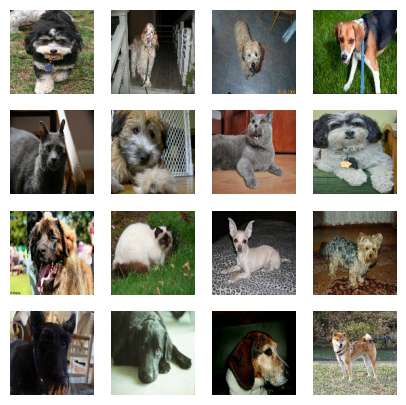

In [11]:
plt.figure(figsize=(5, 5))

df = train_ds.take(1)
for images in df:
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [12]:

def convert_to_float(image):
  return tf.image.convert_image_dtype(image, dtype=tf.float32)

def trans1(img):
  img = tf.image.flip_left_right(img)
  img = tf.image.flip_up_down(img)
  img = tf.image.rot90(img, k=1)
  return img

def trans2(img):
  img = tf.image.rot90(img, k=3)
  return img

def trans3(img):
  img = tf.image.rot90(img, k=1)
  return img

In [13]:

train_a_ds = train_ds
ds2 = train_ds.map(lambda x: trans1(x))
ds3 = train_ds.map(lambda x: trans2(x))
ds4 = train_ds.map(lambda x: trans3(x))

In [14]:

train_a_ds = train_a_ds.concatenate(ds2).concatenate(ds3).concatenate(ds4)
train_a_ds


<_ConcatenateDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>

In [15]:

AUTOTUNE = tf.data.AUTOTUNE
train_a_ds = (
    train_a_ds
    .map(convert_to_float, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


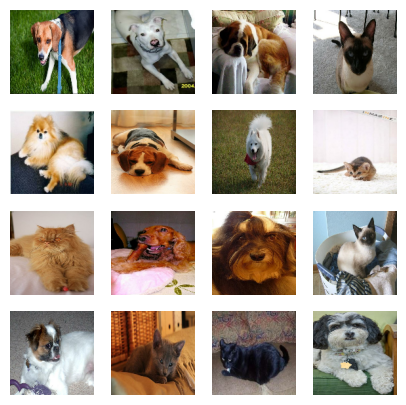

In [16]:

plt.figure(figsize=(5, 5))

df = train_a_ds.take(1)
for images in df:
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [17]:

new_train_ds = train_a_ds.map(lambda x: x / 255.0)

new_train_ds = new_train_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [10]:
codings_size = 128

generator_input_shape = (codings_size,)

generator = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=generator_input_shape), # Add InputLayer with shape
    Dense(64, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    Dense(128, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    Dense(img_height * img_width * band_count, activation="sigmoid"),
    tf.keras.layers.Reshape([img_height, img_width, band_count])
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(128, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    Dense(64, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid") # Booleano para discriminar si es verdadero o falso
])

gan = tf.keras.Sequential([generator, discriminator])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [19]:

discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="adam")

In [20]:
dataset = train_a_ds.shuffle(buffer_size=1000)


In [21]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    print("Epoch {}/{}".format(epoch + 1, n_epochs))
    for X_batch in dataset:
      actual_batch_size = tf.shape(X_batch)[0].numpy()

      # Fase 1 - Entrenar el discriminador
      noise = tf.random.normal(shape=[actual_batch_size, codings_size])
      generated_images = generator(noise)

      X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
      y1 = tf.constant([[0.]] * actual_batch_size + [[1.]] * actual_batch_size)
      discriminator.train_on_batch(X_fake_and_real, y1)

      # Fase 2 - Entrenar el generador
      noise = tf.random.normal(shape=[actual_batch_size, codings_size])
      y2 = tf.constant([[1.]] * actual_batch_size)
      gan.train_on_batch(noise, y2)

In [22]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=100)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78/100
Epoch 7

In [24]:
gan.save("gan.keras")

In [11]:
gan = tf.keras.models.load_model("gan.keras", compile=False)

In [12]:

plt.figure(figsize=(5, 5))
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")


<Figure size 500x500 with 0 Axes>

(24, 128, 128, 3)


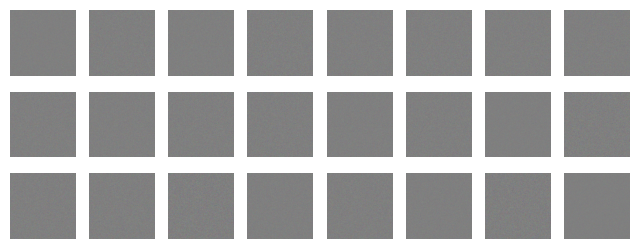

In [13]:

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise, training=False)
print(generated_images.shape)
plot_multiple_images(generated_images, 8)
